# Diode effect notebook 

### Important
* The parameter section must always be executed
* The create device can be modified to merge any kind of device. ( if you're using the default geometries be sure to add their imports from the tdgl)
* The title parameter for the plot_solution function is used for a modified method on the tdgl library to add titles to the obtained figures
### Collab exectution
* If you're using colab a series of small steps are needed:
    * 1. use ctr+H on chrome or ctr+f on vscode(if you're using the new colab extension) to get to the find section, search for df. ,click the arrow left to the writting space and click replace all without typing anything on the replace writting space (if you want to, select the match the whole word button.)
      2. Go to the collab Section
      3. Run the commented step for the installation of the required libraries
      4. Copy the contents of the default_functions.py script into the functions cell
      5. copy the contents of the directories.py(yet to be implemented) script into the dir cell
      6. Remove the lines (if df is not removed):
        * import default_functions as df 
        * d = df.d  gamma = df.gamma
        * xi = df.xi           
        * london_lambda = df.london_lambda  
        * d = df.d               
        * gamma = df.gamma     
After that you'll be good to go
### Some advice
* Any of the functions used in this notebook can be used with any created device. It's just a matter of passing the device object to the function.
* To change the default simulation values you can edit the default_options and default_solutions functions to set the simulation times and any other parameters located on the default_functions.py script
* Each simulation section should run independently of the other sections as long as you've executed the parameters* section(customize the parameters as you see fit)
### Optional
* If your device supports it you can install cuda and run the script on your cpu adding the parameter on the tdgl.options located in the default_options function.
* If you're using a cluster you can divide the work needed to be done on the magnetization,varying currents or varying fields to save time.


# Table of contents
* [Colab](#colab)
* [Parameters*](#parameters) 
* [Simulations:](#simulations) 
    1.  [Different Fields for a Fixed Current](#1) 
    2.  [Zero currents](#zeroCurrents) \
        2.1 [Constant field, Fixed Current](#2.1) \
        2.2 [Varying field, Zero Current](#2.2) \
        2.3 [Fixed field,Zero Current,Different Heights](#2.3)
    3.  [Magnetization](#magnetizations) 
    4.  [Varying Currents](#varyingCurrents) \
       4.1 [Constant field](#4.1)\
       4.2 [Zero field,Different Heights](#4.2)\
       4.3 [Different Fields](#4.3)


# Colab <a name="parameters"></a>

In [ ]:
#if "google.colab" in str(get_ipython()):
#    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
#    !apt install ffmpeg

### Functions

In [ ]:
####################################################
#Copy the contents of the default_functions.py here#
####################################################

### Directories

In [ ]:
####################################################
#Copy the contents of the dir.py here#
####################################################

# Parameters* <a name="parameters"></a>

In [1]:
from tdgl.visualization.animate import create_animation
from tdgl.geometry import box
from IPython.display import HTML, display
from IPython.display import clear_output
from tdgl.sources import ConstantField
import matplotlib.pyplot as plt
import default_functions as df
import numpy as np
import tempfile
import h5py
import tdgl
import time
import os



c:\Users\alejo\anaconda3\envs\electro2\Lib\site-packages\cupy\_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
c:\Users\alejo\anaconda3\envs\electro2\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawk

In [2]:
# ====================================================
# Default configuration
# ====================================================
os.environ["OPENBLAS_NUM_THREADS"] = "1"
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
length_units = "um"     
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0


In [3]:
# ====================================================
## 1. ⚙️Directories and paths for images
# ====================================================



In [4]:

# ====================================================
## 1. ⚙️ Global Parameters(Optimized)
# ====================================================

### 1.1. Material parameters
LENGTH_UNITS = "um"
xi = df.xi           
london_lambda = df.london_lambda  
d = df.d               
gamma = df.gamma            
###Main rectangle
# Ancho del puente (dimensión x)
width_x = 5.0
# Alto del puente (dimensión y)
height_y = 12.0
STRIPE_LENGTH = 0.01   # side of the square contact
OVERLAP = 0.5         # aditional space for overlapping
###Rectangulo pequeño
width_x2 = width_x/2
height_y2 =(height_y/2)+ 1
dimensions = {"width_x":width_x,"width_x2": width_x/2,"height_y":height_y,"height_y2":height_y2}
### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 1.5
MAX_EDGE_LENGTH_VORTEX = xi / 1.5
SMOOTHING_STEPS = 100            
# Geometría inicial y capa
film_poly = tdgl.Polygon("film_base", points=box(width=width_x, height=height_y))
film_poly_down = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=height_y2)).translate(dx=-width_x/2)
half_geometry = film_poly.union(film_poly,film_poly_down)
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=gamma)
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )

widths: width_x:5.0,width_x2:2.5,height_y:12.0,height_y2:7.0,height_y2_altered:3


## Device* <a name="device"></a>

Device and mesh creation

  Malla creada: 2944 puntos


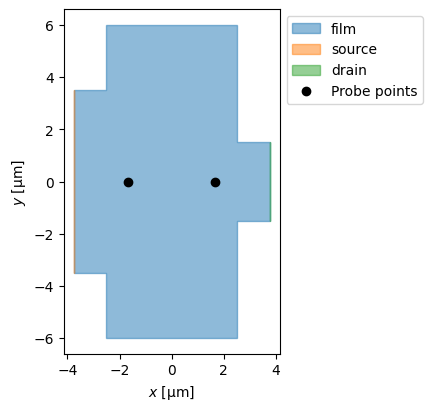

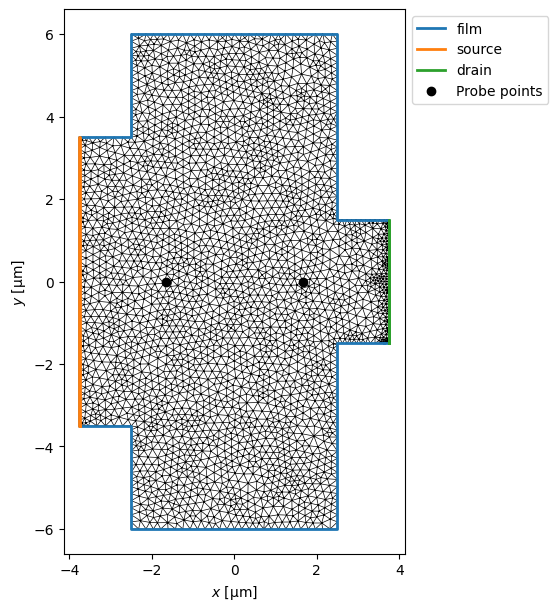

In [5]:
displacement = (width_x + width_x2 + STRIPE_LENGTH) / 2
device_fast = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,incrementy=0,translationx=displacement)
fig, ax = device_fast.plot(mesh=True)

# Simulations <a name="simulations"></a>


## 1) different fields for a fixed current <a name="1"></a>

In [ ]:
# To avoid problems running the simulations code, just delete the used_title variable used in each of the cells and uncomment the one located here
#used_title = None

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpkb9kenxu\zero_field_zero_current-3.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:50<00:00,  3.95tau/s ]


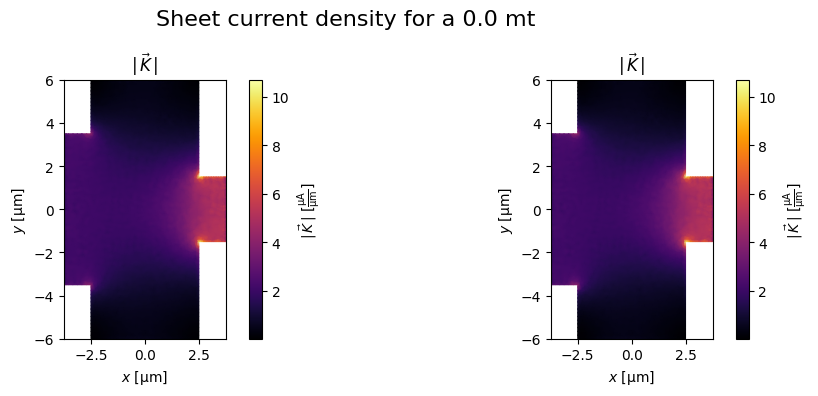

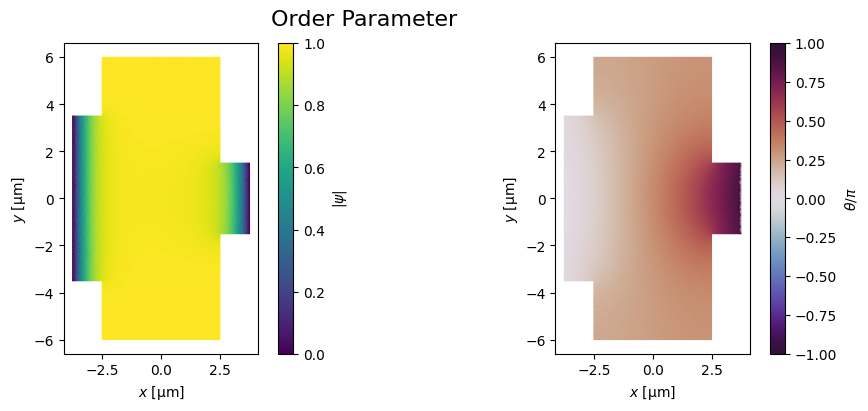

In [9]:
used_field = 0.0
used_title = f'Sheet current density for a {used_field} mt'
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = used_field)
df.plot_solution(zero_field_solution,title=used_title)

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpkb9kenxu\zero_field_zero_current-4.h5.
Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.93tau/s ]


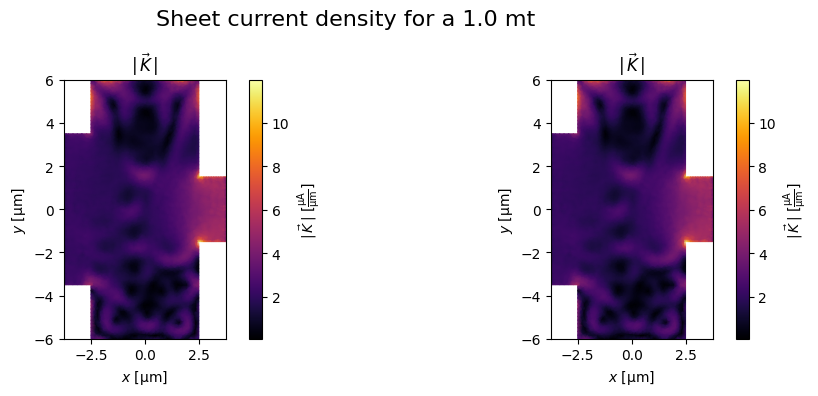

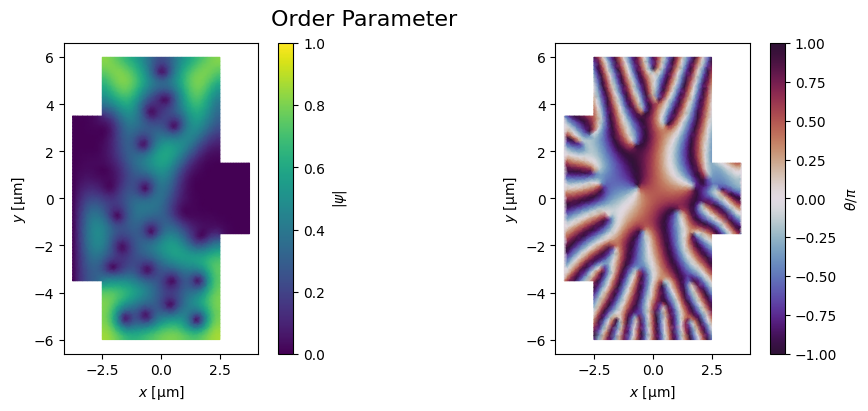

In [10]:
used_field = 1.0
used_title = f'Sheet current density for a {used_field} mt'
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = used_field)
df.plot_solution(zero_field_solution,title=used_title)

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpkb9kenxu\zero_field_zero_current-5.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:46<00:00,  4.28tau/s ]


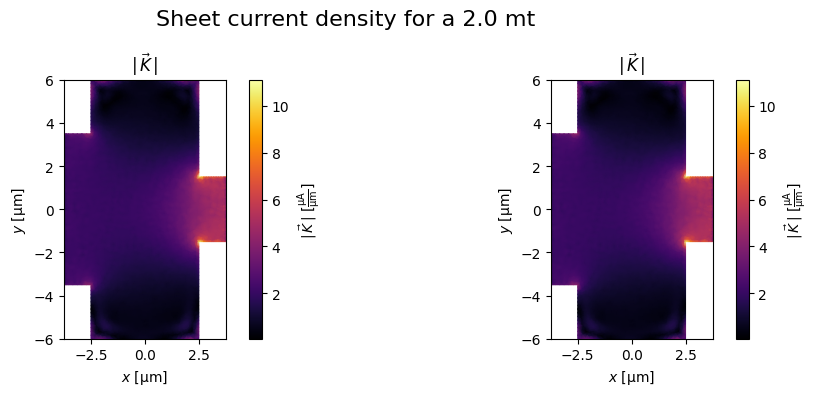

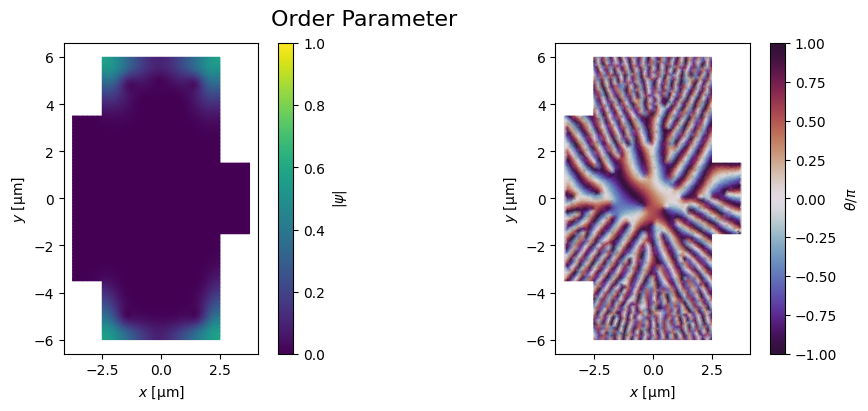

In [11]:
used_field = 2.0
used_title = f'Sheet current density for a {used_field} mt'
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = used_field)
df.plot_solution(zero_field_solution,title=used_title)

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpkb9kenxu\zero_field_zero_current-6.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:42<00:00,  4.69tau/s ]


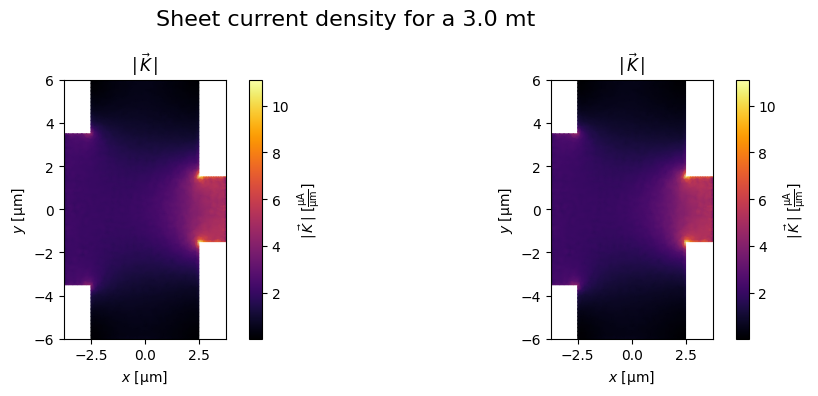

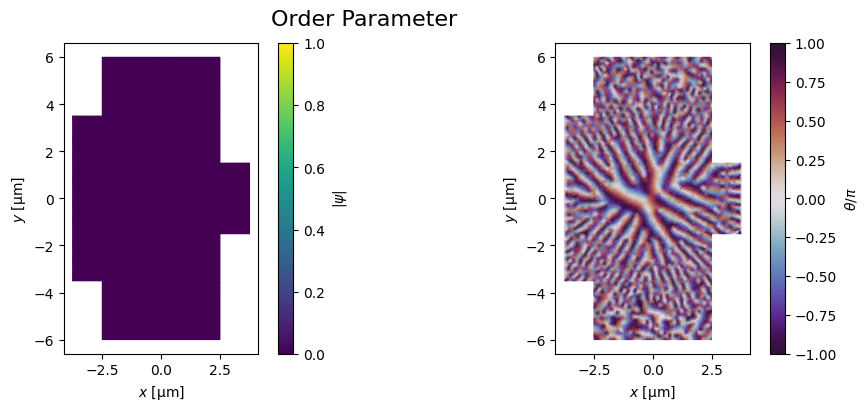

In [12]:
used_field = 3.0
used_title = f'Sheet current density for a {used_field} mt'
zero_field_solution = df.default_solution(device_fast,"zero_field_zero_current.h5",terminal_currents_applied=[15,-15],vector_potential = used_field)
df.plot_solution(zero_field_solution,title=used_title)

## 2)Zero Currents <a name="zeroCurrents"></a>

### 2.1)Cst Field <a name="2.1"></a>

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpkb9kenxu\weak-link-zero-field-1.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:50<00:00,  3.95tau/s ]


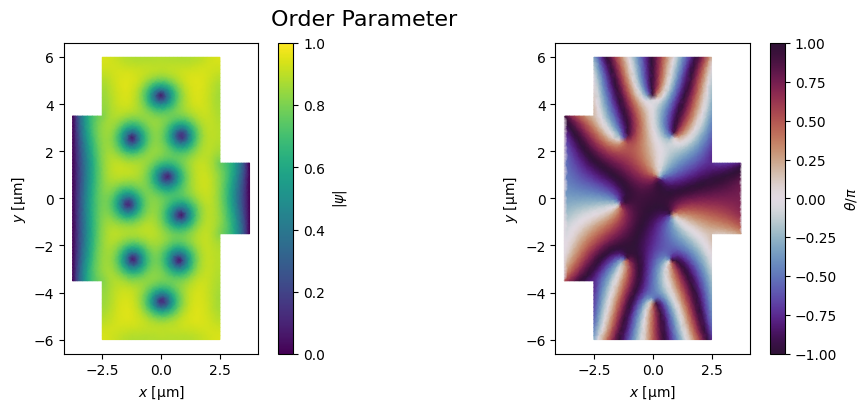

In [14]:
zero_current_solution =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=0.5)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))

### 2.2)varying fields <a name="2.1"></a>

Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:44<00:00,  4.53tau/s ]


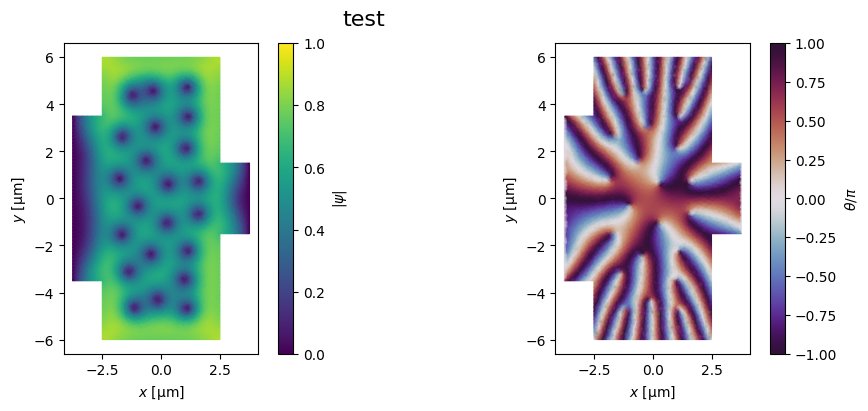

In [6]:
zero_current_solution_2 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_2.plot_order_parameter(figsize=(10, 4),subtitle="test")

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpdc1ht9wr\weak-link-zero-field-1.h5.
Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:38<00:00,  5.13tau/s ]


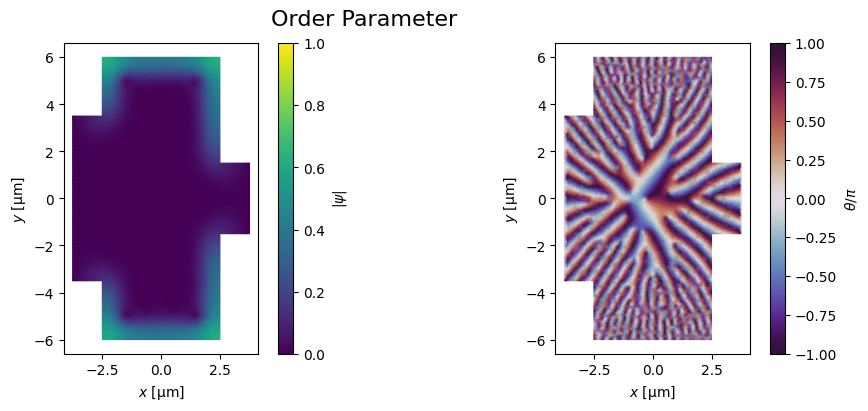

In [7]:
zero_current_solution_3 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=2.0)
fig, axes = zero_current_solution_3.plot_order_parameter(figsize=(10, 4))

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmplsp6_znd\weak-link-zero-field-3.h5.
Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.14tau/s ]


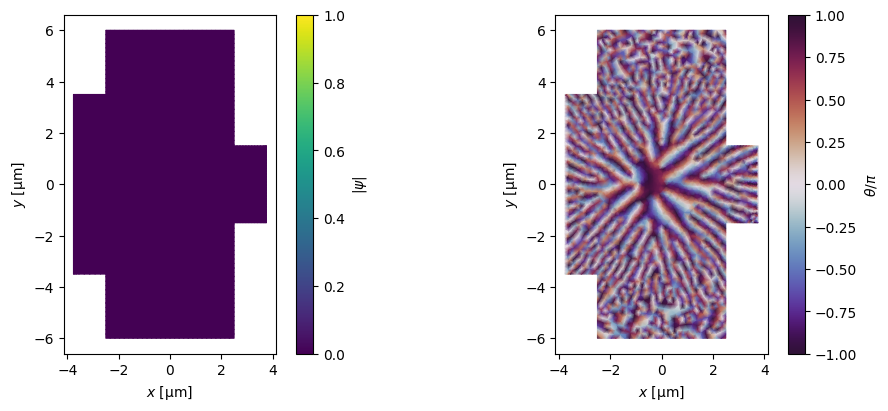

In [12]:
zero_current_solution_4 =  df.default_solution(device_fast, "weak-link-zero-field.h5",vector_potential=3)
fig, axes = zero_current_solution_4.plot_order_parameter(figsize=(10, 4))

In [ ]:
#if MAKE_ANIMATIONS:
#    zero_current_solution_video = df.make_video_from_solution(
#        zero_current_solution,
#        quantities=["order_parameter", "phase", "scalar_potential"],
#        figsize=(6.5, 4),
 
#    )
#    display(zero_current_solution_video)

### 2.3)Fixed field/different height increments <a name="2.3"></a>

  Malla creada: 3132 puntos


Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:55<00:00,  3.62tau/s ]


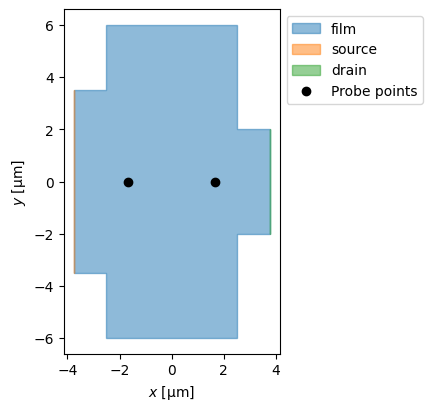

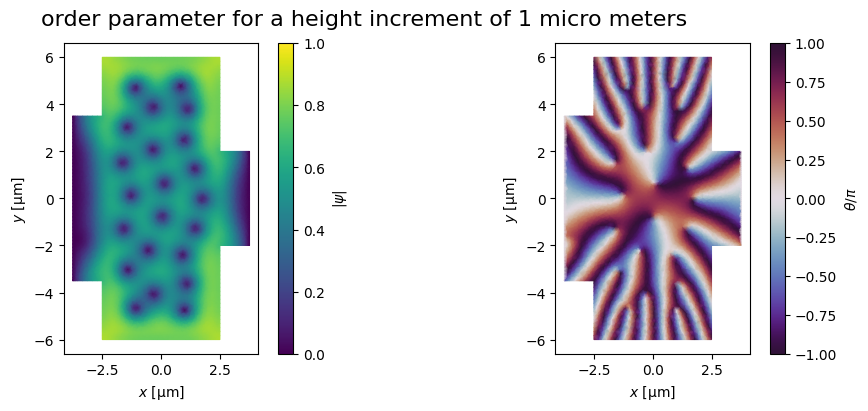

In [ ]:
height_increment = 1
used_subtitle = f'order parameter for a height increment of {height_increment} micro meters'
device_1 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=height_increment)#h = 4
zero_current_solution_1 =  df.default_solution(device_1, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_1.plot_order_parameter(figsize=(10, 4),subtitle=used_subtitle)


In [ ]:
zero_current_solution_1.plot_vorticity(figsize=(10, 4))
zero_current_solution_1.plot_scalar_potential(zero_current_solution_1,figsize=(10,4))

Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpek6k0bst\weak-link-zero-field-1.h5.


  Malla creada: 3387 puntos


Simulating: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:46<00:00,  4.34tau/s ]


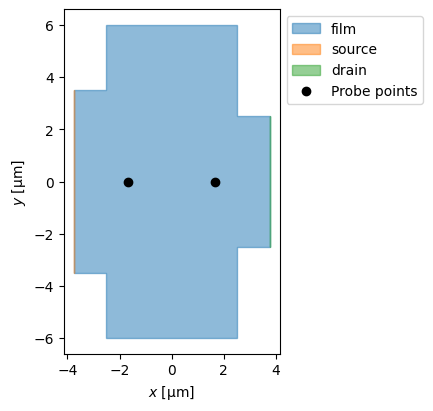

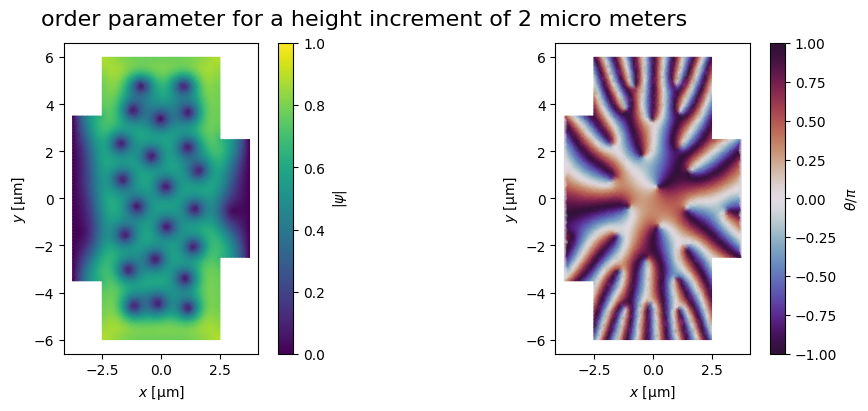

In [8]:
height_increment = 2 
used_subtitle = f'order parameter for a height increment of {height_increment} micro meters'
device_1 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=height_increment)#h = 5 micro m
zero_current_solution_1 =  df.default_solution(device_1, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_1.plot_order_parameter(figsize=(10, 4),subtitle=used_subtitle)


Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpek6k0bst\weak-link-zero-field-2.h5.


  Malla creada: 3148 puntos


Simulating: 100%|█████████████████████████████████████████████████████████████████▉| 200/200 [00:44<00:00,  4.48tau/s ]


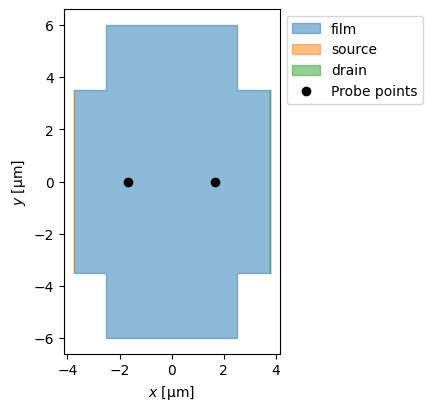

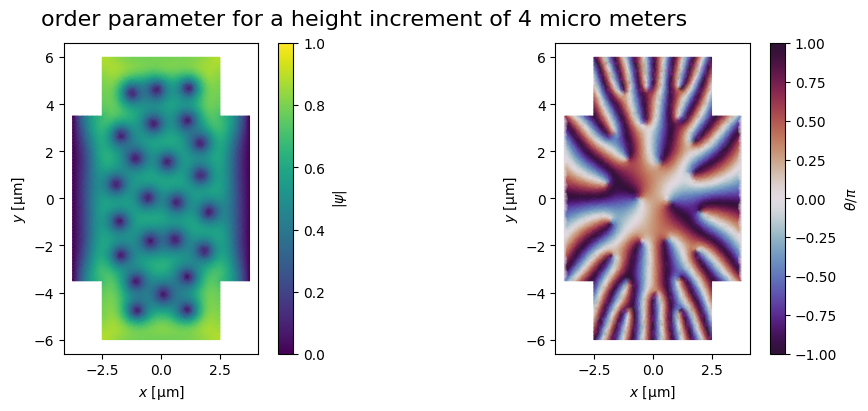

In [ ]:
height_increment = 4
used_subtitle = f'order parameter for a height increment of {height_increment}"+ r"$\mu m$ '
device_1 = df.create_device(film_poly,half_geometry,layer,MAX_EDGE_LENGTH_IV,dimensions,translationx=displacement,incrementy=height_increment)#h = 7 micro m
zero_current_solution_1 =  df.default_solution(device_1, "weak-link-zero-field.h5",vector_potential=1)
fig, axes = zero_current_solution_1.plot_order_parameter(figsize=(10, 4),subtitle=used_subtitle)


## 3)Magnetization <a name="magnetizations"></a>

In [ ]:
# =========================
# 2) Applied field
# =========================
field_o = 0.0
field_f = 2.0
field_steps = 50
applied_field = np.linspace(field_o,field_f,field_steps)  # External field on mT (B)
field_solutions,magnetization,susceptibility = df.solve_field(device_fast,applied_field)
plot_info = plot_labels={"fig_name":"currents.jpg","title":f'applied field vs magnetizations({field_o}–{field_f} mT)',"x":"B [$mT]","y":"magnetization"}
df.plot_parameters(applied_field, -magnetization,color_applied="green",plot_labels = plot_info)

Simulating: 100%|█████████▉| 200/200 [01:04<00:00,  3.09tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpay0osp61\Bscan-1.h5.
Simulating: 100%|██████████| 200/200 [00:59<00:00,  3.36tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpay0osp61\Bscan-2.h5.
Simulating: 100%|█████████▉| 200/200 [01:01<00:00,  3.27tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpay0osp61\Bscan-3.h5.
Simulating: 100%|█████████▉| 200/200 [01:05<00:00,  3.07tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpay0osp61\Bscan-4.h5.
Simulating: 100%|██████████| 200/200 [00:59<00:00,  3.36tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpay0osp61\Bscan-5.h5.
Simulating: 100%|██████████| 200/200 [01:10<00:00,  2.83tau/s ]
Output file already exists. Renaming to C:\Users\alejo\AppData\Local\Temp\tmpay0osp61\Bscan-6.h5.
Simulating: 100%|█████████▉|

## 4) varying currents <a name="varyingCurrents"></a>

### 4.1)Cst field/No height increments <a name="4.1"></a>

For now we make a superficial sweep with a # of steps that allows to see more or less where the critic currents are locted, then we sweep around those points with way more detail.
However i plan to observe the difference between points to see if a current treshold can be applied and automatically  sweep around the critic currents.

In [ ]:
co= 0
ci= 15 # current_interval
steps = 150
currents = np.linspace(co, ci, steps)
#It can also be donde with a linear step increment
#step = 0.5
#curents = np.arange(co, ci, step)
#currents = np.linspace(-ci, ci, steps)

voltages = df.current_application(device_fast, currents,B_field = 1.0)
plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
df.plot_parameters(currents,voltages,plot_info1, plot_type = "scatter")

In [ ]:
def find_critic_regions(device,currents,voltages):
  
    dV_dI = np.gradient(voltages, currents)
    threshold = 0.5 * np.max(dV_dI)
    critic_regions = currents[dV_dI > threshold]
    return critic_regions
critic_regions = find_critic_regions(device_fast,currents)
print(critic_regions)

In [ ]:
def critic_currents_augmentation(device, critic_regions,current_interval, B=1.0, steps=10,critic_steps = 20):
    '''
    A function that applies a current sweep with more defined calculations arround the critic currents to a device and returns the corresponding voltages.
    :param device: tdgl.device object
    :param critic_regions: List or array of current values where the critic regions are located.    
    :param current_interval: Dictionary with the initial and final values of the current interval.
    :param B_field: Double, optional magnetic field to be applied (default is 1.0).
    :param steps: Integer, number of steps for the non-critic regions (default is 10).
    :param critic_steps: Integer, number of steps for the critic regions (default is 20).
    '''
    # the size of the interval, ex: the default interval was 0-15 microA, wich means: size= 15 and current_interval["initial"] = 0 
    size = current_interval["final"]-1
    #The epsilon that sets the total distance of the critic current interval
    epsilon = 1
    cr_size = np.size(critic_regions)
    currents = []
    voltages = []
    for index,i in enumerate(critic_regions):
        #These cases are defined before co and cf are updated
        if index == 0:
            initial = current_interval["initial"]
            #Accsess the first element of critic_regions hence defining the first interval
            final = critic_regions[index] - 0.1
        else:
            #retrieves the previous cf before it's updated
            intial = cf + 0.1
         #Define and updates the critic_currents intrvals set arround an epsilon 
        co =  i - epsilon
        cf =  i + epsilon
        #calculates the next interval from left to right up to the next critic interval
        previous_currents= np.linspace(intial,final,steps)
        previous_voltages = df.current_application(device,previous_currents,B_field = B)
        critic_currents = np.linspace(co, cf, critic_steps)
        critic_voltages = df.current_application(device, critic_currents,B_field = B)
        # Concatenate correctly the whole interval
        current_interval = np.concatenate(previous_currents,critic_currents)
        voltage_interval = np.concatenate(previous_voltages,critic_voltages)
        currents = np.append(current_interval)
        voltages = np.append(voltage_interval)
        plot_info1 = {
        "fig_name": "currents.jpg",
        "title": f'Curva Voltaje vs Corriente ({initial}–{final} µA)',
        "x": "Corriente $I$ [$\mu$A]",
         "y": "Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"
        }
        df.plot_parameters(currents, voltages, plot_info1)
    finalInterval_currents =np.linspace(cf + 0.1,size,steps)
    finalInterval_voltages = df.current_application(device,finalInterval_currents,B_field = B)
    currents.append(finalInterval_currents)
    voltages.append(finalInterval_voltages)
    plot_info1 = {
        "fig_name": "currents.jpg",
        "title": f'Curva Voltaje vs Corriente ({current_interval[0]}–{current_interval[1]} µA)',
        "x": "Corriente $I$ [$\mu$A]",
         "y": "Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"
        }
    
    df.plot_parameters(currents, voltages, plot_info1)
    return currents,voltages


In [ ]:
critical_regions = [3,7,12]
augmented_currents,augmente_voltages = critic_currents_augmentation(device_fast,critical_regions,[co,ci])

### 4.2) Zero field with varying currents and device modifications <a name="4.2"></a>

In [ ]:
print(f'widths: width_x:{width_x},width_x2:{width_x2},height_y:{height_y},height_y2:{height_y2},height_y2_altered:{3}' )


In [ ]:
#height2 = de 4 a 7
io = 1
ifi = 4
size = ifi - io +1
voltages_arr = []
devices_arr = []
J = 0

In [ ]:
voltages_arr = df.varying_increments(half_geometry,currents,io,ifi)

In [ ]:
size = np.size(currents)-1
for j in range(0,3):
    plot_info2 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente variación de x: {j} ({currents[0]}–{currents[size]} µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
    df.plot_parameters(currents,voltages_arr[j],plot_info2)

In [ ]:
plt.scatter(currents,voltages_arr[0],color="blue",label="h=4")
plt.scatter(currents,voltages_arr[1],color="red",label="h=5")
plt.scatter(currents,voltages_arr[2],color="green",label="h=7")
plt.title(plot_info2["title"])
plt.xlabel(plot_info2["x"])
plt.ylabel(plot_info2["y"])
plt.show()

### 4.3) Different fields/varying currents <a name="4.3"></a>

In [ ]:
for applied_field in range(1,4):
    voltages = df.current_application(device_fast, currents,B_field =applied_field)
    actual_voltages = voltages 
    plot_info1 = {"fig_name":"currents.jpg","title":f'Curva Voltaje vs Corriente ({co}–{ci}µA)',"x":"Corriente $I$ [$\mu$A]","y":"Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]"}
    df.plot_parameters(currents,actual_voltages,plot_info1)